In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from termcolor import colored as cl
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.model_selection import train_test_split # data split
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.linear_model import LogisticRegression # Logistic regression algorithm
from sklearn.svm import SVC # SVM algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from xgboost import XGBClassifier # XGBoost algorithm

from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

In [2]:
url = "https://drive.google.com/file/d/17GNz5plFUeXoiUngnnI_wdaRuIqWDw6_/view?usp=sharing"
df = pd.read_csv("data-sources/creditcard.csv")
print(df.head(5), "\n", df.tail(5))

ParserError: Error tokenizing data. C error: Expected 294 fields in line 127, saw 440


In [5]:
print("Dataset Shape:", df.shape, "\n")
print(df.columns)

Dataset Shape: (284807, 31) 

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [7]:
# sample 30% of the dataset
dfsample = df.sample(frac = 0.3, random_state= 42)
print("Shape of the Dataset: ", dfsample.shape)

Shape of the Dataset:  (85442, 31)


In [9]:

# Determine number of fraud cases in Dataset

Fraud = dfsample[dfsample['Class'] == 1]
Valid = dfsample[dfsample['Class'] == 0]

outlier_fraction = (len(Fraud)/float(len(Valid)))
print("Outlier_fraction: {0} %".format(outlier_fraction*100))

print('Fraud Cases: {}'.format(len(dfsample[dfsample['Class'] == 1])))
print('Valid Transactions: {}'.format(len(dfsample[dfsample['Class'] == 0])))

Outlier_fraction: 0.15942606616181745 %
Fraud Cases: 136
Valid Transactions: 85306


In [10]:

print("Description of the Dataset: ", dfsample.describe())

Description of the Dataset:                  Time            V1            V2            V3            V4  \
count   85442.000000  85442.000000  85442.000000  85442.000000  85442.000000   
mean    94967.874862      0.003465      0.005440     -0.004776      0.002485   
std     47520.526676      1.953426      1.611981      1.520529      1.413738   
min         0.000000    -37.558067    -48.060856    -33.680984     -5.600607   
25%     54257.500000     -0.918861     -0.597627     -0.898758     -0.845937   
50%     84962.000000      0.027558      0.063774      0.172342     -0.015543   
75%    139498.000000      1.318759      0.804713      1.024434      0.748582   
max    172787.000000      2.439207     21.467203      9.382558     12.699542   

                 V5            V6            V7            V8            V9  \
count  85442.000000  85442.000000  85442.000000  85442.000000  85442.000000   
mean      -0.001153      0.004429     -0.006112      0.002718      0.000754   
std        1.

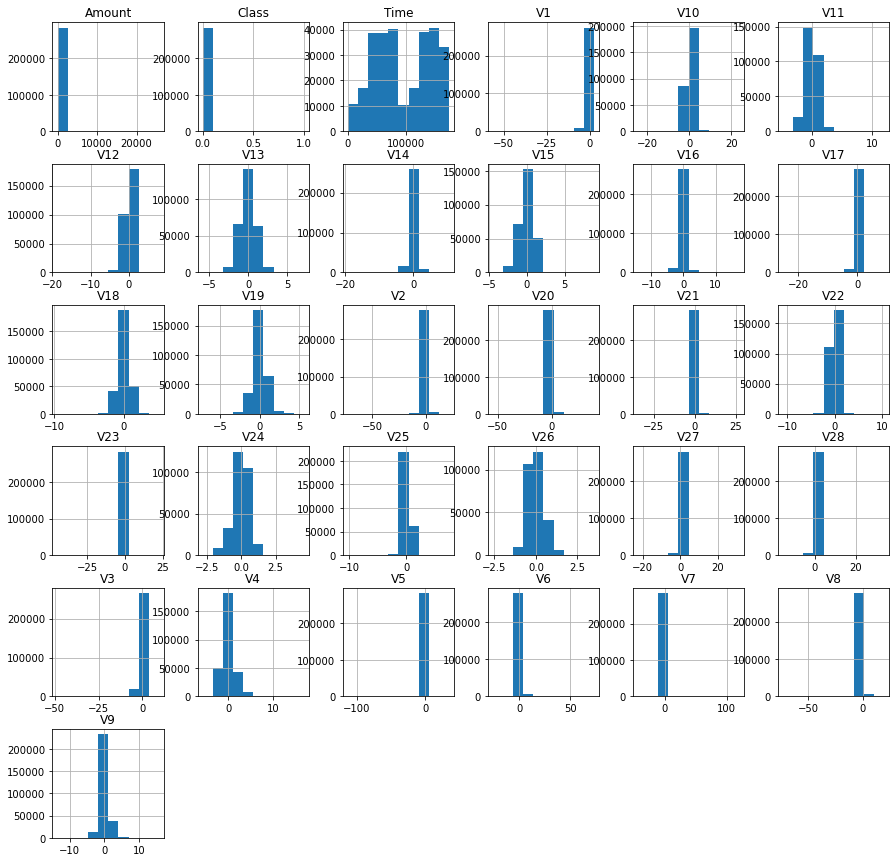

In [11]:
df.hist(figsize = (15, 15))
plt.show()

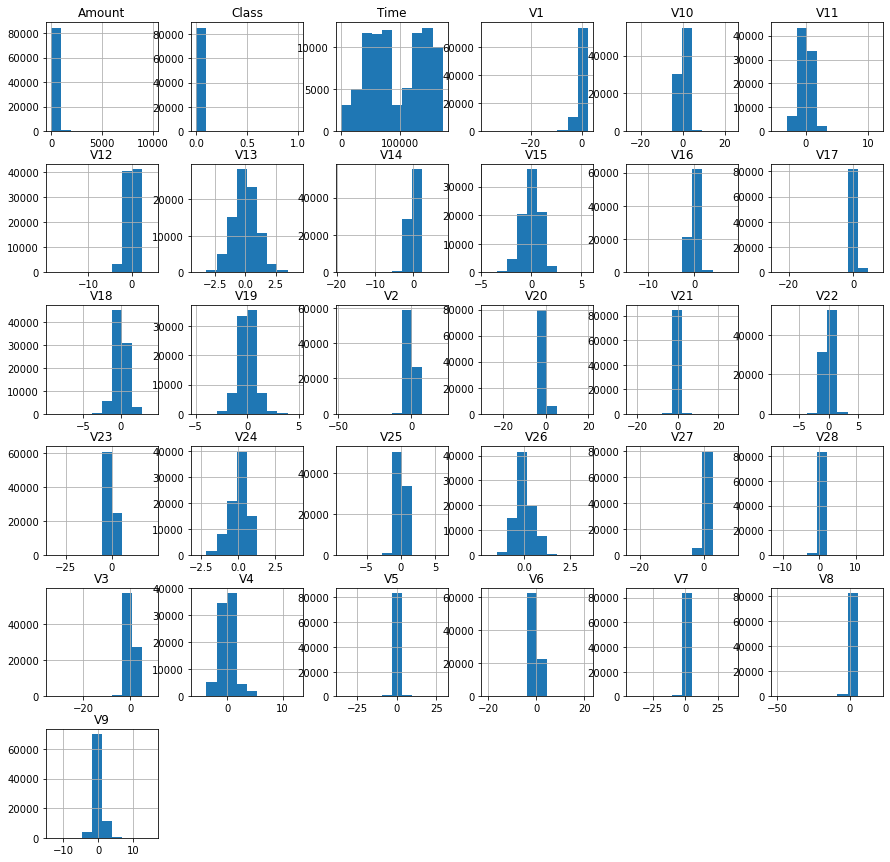

In [12]:
dfsample.hist(figsize = (15, 15))
plt.show()

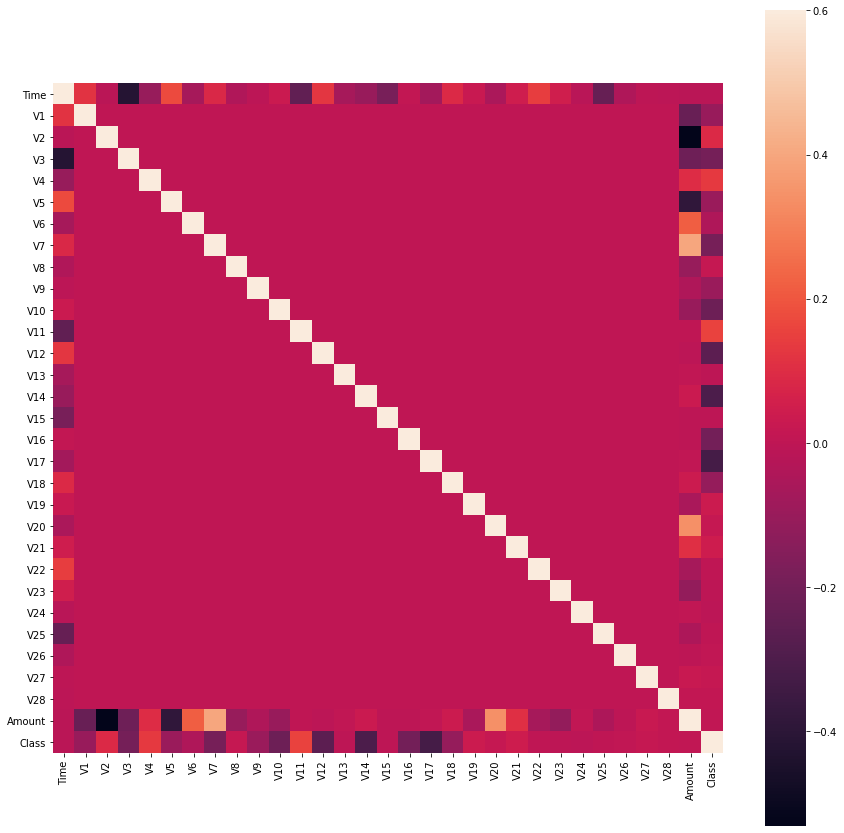

In [14]:
# Correlation matrix

corrmat = df.corr()
fig = plt.figure(figsize = (15, 15))

#Plotting a heatmap to visualize the correlation matrix and see features 
# with strong correlation to the target class
sns.heatmap(corrmat, vmax = .6, square = True)
plt.show()

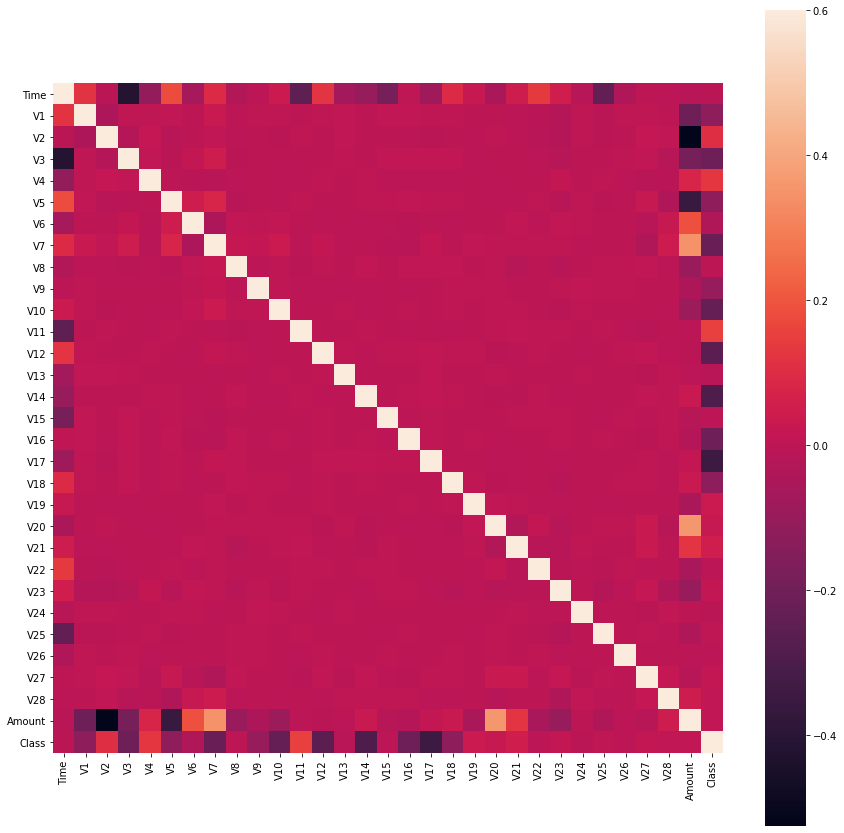

In [15]:
corrmat = dfsample.corr()
fig = plt.figure(figsize = (15, 15))

#Plotting a heatmap to visualize the correlation matrix and see features 
# with strong correlation to the target class
sns.heatmap(corrmat, vmax = .6, square = True)
plt.show()

In [16]:
corrmat['Class']

Time     -0.008402
V1       -0.121864
V2        0.105051
V3       -0.208042
V4        0.128095
V5       -0.118543
V6       -0.038185
V7       -0.217359
V8       -0.001888
V9       -0.099826
V10      -0.228272
V11       0.153159
V12      -0.256577
V13      -0.012188
V14      -0.294882
V15      -0.006388
V16      -0.205082
V17      -0.345739
V18      -0.121619
V19       0.034440
V20       0.025939
V21       0.052617
V22      -0.003520
V23       0.011271
V24      -0.006823
V25       0.005641
V26      -0.002010
V27       0.013635
V28       0.007974
Amount    0.009849
Class     1.000000
Name: Class, dtype: float64

In [17]:
cols = corrmat.keys()
cols_to_keep = []

for i in range(len(corrmat)):
    
    if abs(corrmat['Class'][i]) > 0.01:
        
        cols_to_keep.append(cols[i])

In [20]:
len(cols_to_keep)
cols = cols_to_keep[:-1]

In [22]:
features = dfsample[cols] # records of all transactions, excluding the target class
target = dfsample["Class"] # records of the corresponding label for each record

print(features.shape)
print(target.shape)

(85442, 21)
(85442,)


In [23]:
# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "IF": IsolationForest(max_samples = len(features),
                                        contamination = outlier_fraction,
                                        random_state = state),
    "LOF": LocalOutlierFactor(
        n_neighbors = 20,
        contamination = outlier_fraction)}

In [24]:
n_outliers = len(Fraud)

# Fit the model
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the dataframe and tag outliers
    if clf_name == "LOF":
        
        y_pred = clf.fit_predict(features)
        scores_pred = clf.negative_outlier_factor_
        
    else:
        
        # train/fit classifier on our features
        clf.fit(features)
        # generate predictions 
        scores_pred = clf.decision_function(features)
        y_pred = clf.predict(features)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud.
    
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != target).sum()
    
    # Run classification metrics
    print('Classifier {0}: \nNumber of Errors: {1}'.format(clf_name, n_errors))
    print('Accuracy: {0}%\n'.format(accuracy_score(target, y_pred)*100))
    print(classification_report(target, y_pred))

Classifier IF: 
Number of Errors: 173
Accuracy: 99.797523466211%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85306
           1       0.36      0.37      0.37       136

    accuracy                           1.00     85442
   macro avg       0.68      0.68      0.68     85442
weighted avg       1.00      1.00      1.00     85442

Classifier LOF: 
Number of Errors: 273
Accuracy: 99.68048500737342%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85306
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85442
   macro avg       0.50      0.50      0.50     85442
weighted avg       1.00      1.00      1.00     85442



In [30]:
cases = len(df)
nonfraud_count = len(df[df.Class == 0])
fraud_count = len(df[df.Class == 1])
fraud_percentage = round(fraud_count/nonfraud_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(nonfraud_count), attrs = ['bold']))
print(cl('Number of Non-fraud cases are {}'.format(fraud_count), attrs = ['bold']))
print(cl('Percentage of fraud cases is {}'.format(fraud_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 284807
Number of Non-fraud cases are 284315
Number of Non-fraud cases are 492
Percentage of fraud cases is 0.17
--------------------------------------------


In [31]:
nonfraud_cases = df[df.Class == 0]
fraud_cases = df[df.Class == 1]

print(cl('CASE AMOUNT STATISTICS', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('NON-FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(nonfraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('FRAUD CASE AMOUNT STATS', attrs = ['bold']))
print(fraud_cases.Amount.describe())
print(cl('--------------------------------------------', attrs = ['bold']))

CASE AMOUNT STATISTICS
--------------------------------------------
NON-FRAUD CASE AMOUNT STATS
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
--------------------------------------------
FRAUD CASE AMOUNT STATS
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
--------------------------------------------


In [33]:
sc = StandardScaler()
amount = df['Amount'].values

df['Amount'] = sc.fit_transform(amount.reshape(-1, 1))

print(cl(df['Amount'].head(10), attrs = ['bold']))

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
5   -0.338556
6   -0.333279
7   -0.190107
8    0.019392
9   -0.338516
Name: Amount, dtype: float64


In [39]:
X = df.drop('Class', axis = 1).values
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(cl('X_train samples : ', attrs = ['bold']), X_train[:1])
print(cl('X_test samples : ', attrs = ['bold']), X_test[0:1])
print(cl('y_train samples : ', attrs = ['bold']), y_train[0:20])
print(cl('y_test samples : ', attrs = ['bold']), y_test[0:20])

X_train samples :  [[ 5.31500000e+04 -1.11504743e+00  1.03558276e+00  8.00712441e-01
  -1.06039825e+00  3.26211690e-02  8.53422160e-01 -6.14243480e-01
  -3.23116112e+00  1.53994798e+00 -8.16908791e-01 -1.30559201e+00
   1.08177199e-01 -8.59609580e-01 -7.19342108e-02  9.06655628e-01
  -1.72092961e+00  7.97853221e-01 -6.75939779e-03  1.95677806e+00
  -6.44895565e-01  3.02038533e+00 -5.39617976e-01  3.31564886e-02
  -7.74945766e-01  1.05867812e-01 -4.30853482e-01  2.29736936e-01
  -7.05913036e-02 -3.01454177e-01]]
X_test samples :  [[ 1.25821000e+05 -3.23333572e-01  1.05745525e+00 -4.83411518e-02
  -6.07204308e-01  1.25982115e+00 -9.17607168e-02  1.15910150e+00
  -1.24334606e-01 -1.74639536e-01 -1.64440065e+00 -1.11886302e+00
   2.02647310e-01  1.14596495e+00 -1.80235956e+00 -2.47177932e-01
  -6.09453515e-02  8.46605738e-01  3.79454387e-01  8.47262245e-01
   1.86409421e-01 -2.07098267e-01 -4.33890272e-01 -2.61613283e-01
  -4.66506063e-02  2.11512300e-01  8.29721214e-03  1.08494430e-01
   

In [41]:
# 1. Decision Tree

tree_model = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
tree_model.fit(X_train, y_train)
tree_yhat = tree_model.predict(X_test)

# 2. K-Nearest Neighbors

n = 5

knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)

# 3. Logistic Regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

# 4. SVM 

svm = SVC()
svm.fit(X_train, y_train)
svm_yhat = svm.predict(X_test)

# 5. Random Forest Tree

rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

# 6. XGBoost

xgb = XGBClassifier(max_depth = 4)
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

[09:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
print(cl('ACCURACY SCORE', attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the Decision Tree model is {}'.format(accuracy_score(y_test, tree_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the KNN model is {}'.format(accuracy_score(y_test, knn_yhat)), attrs = ['bold'], color = 'green'))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the Logistic Regression model is {}'.format(accuracy_score(y_test, lr_yhat)), attrs = ['bold'], color = 'red'))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the SVM model is {}'.format(accuracy_score(y_test, svm_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the Random Forest Tree model is {}'.format(accuracy_score(y_test, rf_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('Accuracy score of the XGBoost model is {}'.format(accuracy_score(y_test, xgb_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))


ACCURACY SCORE
------------------------------------------------------------------------
Accuracy score of the Decision Tree model is 0.9993679997191109
------------------------------------------------------------------------
Accuracy score of the KNN model is 0.9983848881710614
------------------------------------------------------------------------
Accuracy score of the Logistic Regression model is 0.9990168884519505
------------------------------------------------------------------------
Accuracy score of the SVM model is 0.9982268881008391
------------------------------------------------------------------------
Accuracy score of the Random Forest Tree model is 0.9992977774656788
------------------------------------------------------------------------
Accuracy score of the XGBoost model is 0.9995084442259752
------------------------------------------------------------------------


In [43]:
print(cl('F1 SCORE', attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the Decision Tree model is {}'.format(f1_score(y_test, tree_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the KNN model is {}'.format(f1_score(y_test, knn_yhat)), attrs = ['bold'], color = 'green'))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the Logistic Regression model is {}'.format(f1_score(y_test, lr_yhat)), attrs = ['bold'], color = 'red'))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the SVM model is {}'.format(f1_score(y_test, svm_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the Random Forest Tree model is {}'.format(f1_score(y_test, rf_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))
print(cl('F1 score of the XGBoost model is {}'.format(f1_score(y_test, xgb_yhat)), attrs = ['bold']))
print(cl('------------------------------------------------------------------------', attrs = ['bold']))


F1 SCORE
------------------------------------------------------------------------
F1 score of the Decision Tree model is 0.8105263157894738
------------------------------------------------------------------------
F1 score of the KNN model is 0.1636363636363636
------------------------------------------------------------------------
F1 score of the Logistic Regression model is 0.7333333333333334
------------------------------------------------------------------------
F1 score of the SVM model is 0.0
------------------------------------------------------------------------
F1 score of the Random Forest Tree model is 0.7701149425287357
------------------------------------------------------------------------
F1 score of the XGBoost model is 0.851063829787234
------------------------------------------------------------------------


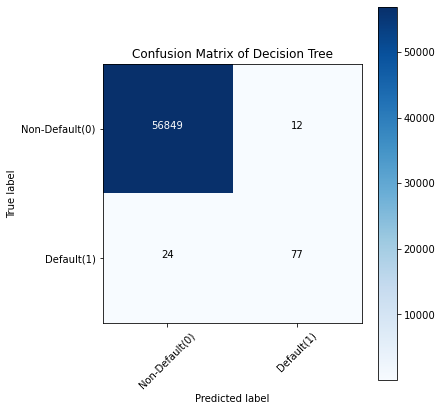

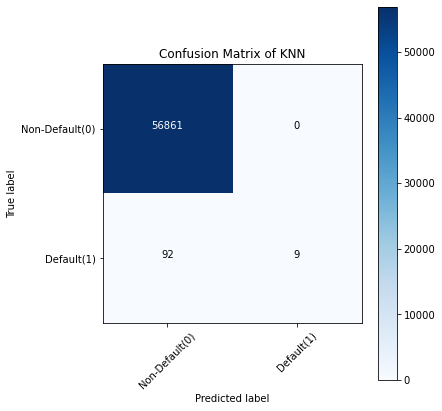

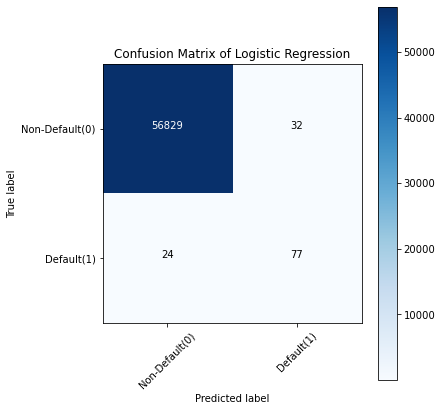

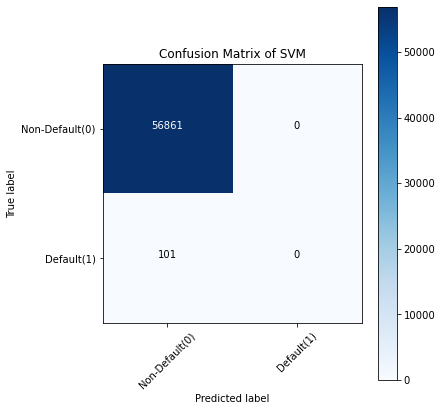

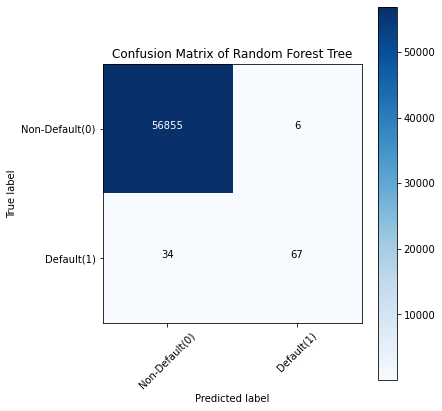

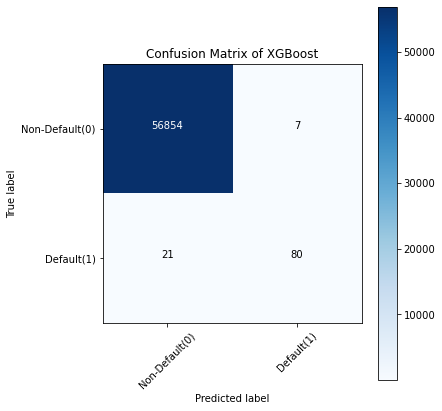

In [48]:
def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for the models

tree_matrix = confusion_matrix(y_test, tree_yhat, labels = [0, 1]) # Decision Tree
knn_matrix = confusion_matrix(y_test, knn_yhat, labels = [0, 1]) # K-Nearest Neighbors
lr_matrix = confusion_matrix(y_test, lr_yhat, labels = [0, 1]) # Logistic Regression
svm_matrix = confusion_matrix(y_test, svm_yhat, labels = [0, 1]) # Support Vector Machine
rf_matrix = confusion_matrix(y_test, rf_yhat, labels = [0, 1]) # Random Forest Tree
xgb_matrix = confusion_matrix(y_test, xgb_yhat, labels = [0, 1]) # XGBoost

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

# 1. Decision tree

tree_cm_plot = plot_confusion_matrix(tree_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Decision Tree')
#plt.savefig('tree_cm_plot.png')
plt.show()

# 2. K-Nearest Neighbors

knn_cm_plot = plot_confusion_matrix(knn_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'KNN')
#plt.savefig('knn_cm_plot.png')
plt.show()

# 3. Logistic regression

lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Logistic Regression')
#plt.savefig('lr_cm_plot.png')
plt.show()

# 4. Support Vector Machine

svm_cm_plot = plot_confusion_matrix(svm_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'SVM')
#plt.savefig('svm_cm_plot.png')
plt.show()

# 5. Random forest tree

rf_cm_plot = plot_confusion_matrix(rf_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Random Forest Tree')
#plt.savefig('rf_cm_plot.png')
plt.show()

# 6. XGBoost

xgb_cm_plot = plot_confusion_matrix(xgb_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'XGBoost')
#plt.savefig('xgb_cm_plot.png')
plt.show()